In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel

In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    s2 = Q/N
    vs2 = s2/N
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    vB = (1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr)/tmp
    return s2,vs2,B,vB

def OUresult(data,deltat):
    s2, vs2, B ,vB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*np.sqrt(vB)/B/np.log(B)**2
    return s2,np.sqrt(vs2),tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<Container object of 3 artists>

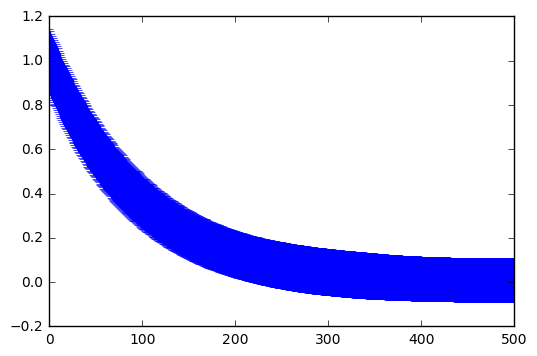

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

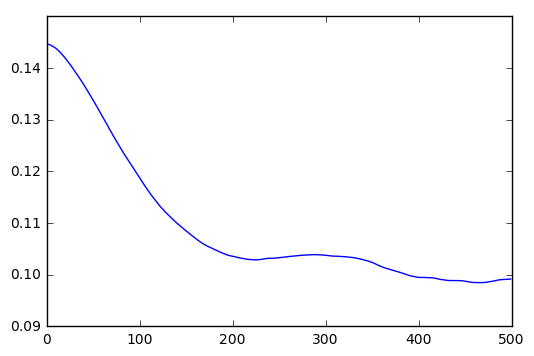

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [8]:
result_array = None
for y in acf_all:
    print("***** Iteration ",i," *****")
    mod = ExponentialModel()
    pars = mod.guess(y, x=t)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            np.sqrt(out.covar[0,0])*delta_t,
                            out.values['amplitude'],
                            np.sqrt(out.covar[1,1])])
        print(out.fit_report(min_correl=0.25))
        
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = np.zeros(4)
        print('fit did not work')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            np.sqrt(out2.covar[0,0])*delta_t,
                            out2.values['amplitude'],
                            np.sqrt(out2.covar[1,1])])
        print(out2.fit_report(min_correl=0.25))

    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  999  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 0.964
    reduced chi-square = 0.002
    Akaike info crit   = -3119.625
    Bayesian info crit = -3111.196
[[Variables]]
    amplitude:   0.79341571 +/- 0.008377 (1.06%) (init= 1.103962)
    decay:       108.711234 +/- 1.634891 (1.50%) (init= 95.16975)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.705 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 24
    # data points      = 500
    # variables        = 2
    chi-square         = 77.987
    reduced chi-square = 0.157
    Akaike info crit   = -923.026
    Bayesian info crit = -914.597
[[Variables]]
    amplitude:   0.75869309 +/- 0.009835 (1.30%) (init= 1.103962)
    decay:       116.211251 +/- 1.827068 (1.57%) (init= 95.16975)
[[Correlations]] (unreported correlations are

(array([ 0.04401747,  0.52820966,  1.38655036,  2.61903957,  2.82812256,
         1.92576439,  0.90235817,  0.40716161,  0.29711793,  0.06602621]),
 array([ 0.59495071,  0.68582372,  0.77669673,  0.86756973,  0.95844274,
         1.04931575,  1.14018875,  1.23106176,  1.32193477,  1.41280777,
         1.50368078]),
 <a list of 10 Patch objects>)

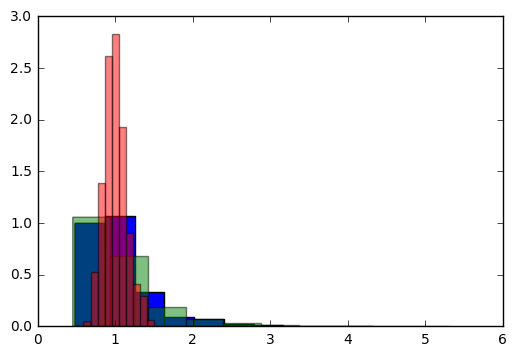

In [9]:
# decay time
plt.hist(result_array.T[0],normed=True)
plt.hist(result_array.T[4],normed=True,alpha=0.5)
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.5)

(array([   3.,   38.,  111.,  237.,  264.,  178.,   89.,   48.,   24.,    8.]),
 array([ 0.58624584,  0.67701569,  0.76778554,  0.8585554 ,  0.94932525,
         1.0400951 ,  1.13086496,  1.22163481,  1.31240467,  1.40317452,
         1.49394437]),
 <a list of 10 Patch objects>)

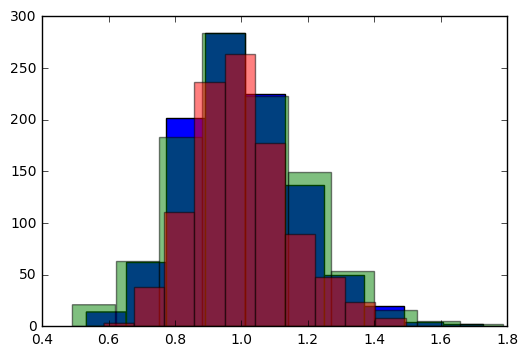

In [10]:
# amplitude
plt.hist(result_array.T[2])
plt.hist(result_array.T[6],alpha=0.5)
plt.hist(result_Bayes_array.T[0],alpha=0.5)